Date: 06/10/2019

Version: 6.0

Environment: Python 3.7.0 and Anaconda 2019.07 (64-bit)

Libraries used:
* pandas 0.24.2 (for data frame, included in Anaconda Python 3.7) 
* networkx 2.3 (for distance graph, included in Anaconda Python 3.7)
* datetime (for datetime conversion, included in Anaconda Python 3.7)
* sklearn.linear_model (LinearRegression - for delivery fee prediction)
* re 2.2.1 (for regex pattern matching, included in Anaconda Python 3.7)
* numpy 1.16.4 (for numpy array and order price computation, included in Anaconda Python 3.7)
* matplotlib.pyplot (for plotting graphs, included in Anaconda Python 3.7)
* math (for identifying NaN values, included in Anaconda Python 3.7)


## Introduction

This assignment requires us to analyze, find and fix the problems in the dataset. We have to perform graphical and/or non-graphical EDA methods to understand the data first and then find the data problems. We are required to:

- Detect and fix errors in Group010_dirty_data.csv
- Detect and remove outlier rows in Group010_outlier_data.csv (outliers are to be found w.r.t. delivery_fee attribute)
- Impute the missing values in Group010_missing_data.csv

As per the specifications, the dataset contains Food Delivery data from a restaurant in Melbourne, Australia. The restaurant has three branches around CBD area. All three branches share the same menu but they have different management so they operate differently.    

More details will be provided in the following sections.

## Importing required libraries

In [1]:
# To work with dataframes 
import pandas as pd

# For datetime formatting
from datetime import datetime

# For Dijkstra's Algorithm
import networkx as nx

# For linear regression
from sklearn.linear_model import LinearRegression

# For using regex library
import re

# For using numpy library
import numpy as np

# To plot graphs
import matplotlib.pyplot as plt
%matplotlib inline

# To check for nulls in the missing data section
import math

# For logistic regression
from sklearn.linear_model import LogisticRegression

# Loading the data

Here, we create dataframes for each data file provided.

In [2]:
# Creating dataframe for dirty data
dirtyData = pd.read_csv('Group010_dirty_data.csv')

# Creating dataframe for missing data
missingData = pd.read_csv('Group010_missing_data.csv')

# Creating dataframe for outlier data
outlierData = pd.read_csv('Group010_outlier_data.csv')

# Creating dataframe for branches data
branches = pd.read_csv('branches.csv')

# Creating dataframe for nodes data
nodes = pd.read_csv('nodes.csv')

# Creating dataframe for edges data
edges = pd.read_csv('edges.csv')

# Outlier Data

As per the specification, there are no anomalies in the outliers csv file except for the outliers. Hence we use this file to detect and remove outliers and use this data as reference for the missing and dirty data. Let's check for the dimensions of the outiers data.

In [3]:
# Check the dimensions of the data
outlierData.shape

(500, 12)

Since outliers are based on delivery fee which in turn is dependent on branch code, we perform some preliminary analysis to figure out the calculations to detect and remove outliers.

In [4]:
# preliminary form of data analysis to check the content of the outlierData dataframe
outlierData[outlierData['branch_code']=='NS'].describe()

,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
count,164.000000,164.000000,164.000000,164.00000,164.000000,164.000000
mean,489.397256,-37.812642,144.968954,0.02439,8.894689,14.504626
std,273.018050,0.007777,0.021799,0.15473,1.136079,2.612485
min,29.500000,-37.827676,144.927106,0.00000,6.376000,6.274146
25%,254.950000,-37.819037,144.952628,0.00000,7.984750,13.626231
50%,437.200000,-37.812974,144.965306,0.00000,8.942500,14.706808
75%,661.100000,-37.806316,144.985131,0.00000,9.715000,15.645474
max,1315.000000,-37.796740,145.015651,1.00000,11.815000,24.587397


In [5]:
# preliminary form of data analysis to check the content of the outlierData dataframe
outlierData[outlierData['branch_code']=='BK'].describe()

,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
count,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000
mean,502.444379,-37.812489,144.966972,0.047337,7.730586,13.977532
std,260.326992,0.008220,0.023415,0.212990,1.952473,3.575330
min,66.000000,-37.827954,144.910758,0.000000,3.827000,5.417400
25%,308.250000,-37.819137,144.951600,0.000000,6.521000,11.470013
50%,461.000000,-37.813178,144.964142,0.000000,7.834000,14.106258
75%,663.000000,-37.804742,144.983826,0.000000,8.822000,15.939524
max,1207.000000,-37.794980,145.018672,1.000000,12.933000,27.349952


In [6]:
# preliminary form of data analysis to check the content of the outlierData dataframe
outlierData[outlierData['branch_code']=='TP'].describe()

,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
count,167.000000,167.000000,167.000000,167.000000,167.00000,167.000000
mean,494.797305,-37.812351,144.966087,0.041916,9.66415,13.211146
std,257.522649,0.007574,0.021690,0.201000,1.33555,2.476505
min,44.500000,-37.828229,144.925859,0.000000,7.36900,5.380318
25%,304.800000,-37.818596,144.950687,0.000000,8.69900,12.204025
50%,461.000000,-37.813119,144.963154,0.000000,9.50800,13.381728
75%,623.500000,-37.805861,144.982240,0.000000,10.41900,14.558865
max,1312.000000,-37.793879,145.015586,1.000000,13.77400,20.413104


We now plot outliers using the boxplot for outliers data, check for outliers and remove them.

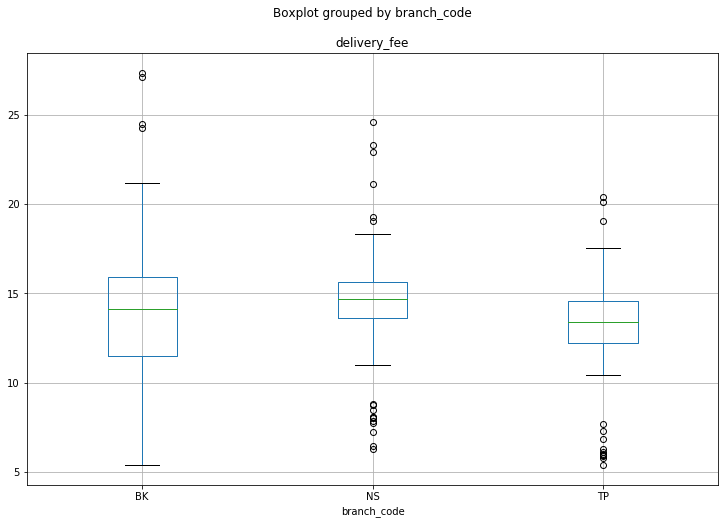

In [7]:
# Generating outliers from outlier data
outlierData.boxplot(column='delivery_fee', by = 'branch_code', figsize=[12,8])

We can see in the above graph that there are few outliers for each branch. Below is the code to find out the upper and lower boundary points for each branch. Here, we use IQR method to identify lower and upper boundary points. The points which lie beyond these boundary points are considered as outliers and are to be removed.

In [8]:
def findQuantile(totalList):
    arr = np.array(totalList)                                             # Convert the list to numpy array
    upperQuartile = np.percentile(arr, 75)                                # Calculate 75th percentile value (Q3)
    lowerQuartile = np.percentile(arr, 25)                                # Calculate 25th percentile value (Q1)
    IQR = upperQuartile - lowerQuartile                                   # Calculate IQR (Q3 - Q1)
    quartileSet = (lowerQuartile - (1.5*IQR), upperQuartile + (1.5*IQR))  # Calculate lower and upper boundary points
    
    return quartileSet

In [9]:
# Initializing empty lists for each branch
listBK = []
listNS = []
listTP = []

# Splitting outlier data for delivery fee based on branch code
for index, row in outlierData.iterrows():
    if outlierData.at[index, 'branch_code'] == 'BK':
        listBK.append(outlierData.at[index, 'delivery_fee'])
    elif outlierData.at[index, 'branch_code'] == 'NS':
        listNS.append(outlierData.at[index, 'delivery_fee'])
    else:
        listTP.append(outlierData.at[index, 'delivery_fee'])

In [10]:
# Finding quantile set(Q3 and Q1) for each branch

quantileSetBK = findQuantile(listBK)
quantileSetNS = findQuantile(listNS)
quantileSetTP = findQuantile(listTP)

print('lower and upper boundary points for outlier data (BK) : ', quantileSetBK)
print('lower and upper boundary points for outlier data (NS) : ', quantileSetNS)
print('lower and upper boundary points for outlier data (TP) : ', quantileSetTP)

lower and upper boundary points for outlier data (BK) :  (4.7657459, 22.6437915)
lower and upper boundary points for outlier data (NS) :  (10.597365087499995, 18.674339987500005)
lower and upper boundary points for outlier data (TP) :  (8.67176525, 18.09112485)


In [11]:
# For each branch we check for the outliers and remove them

for index, row in outlierData.iterrows():
    # For branch BK
    if outlierData.at[index, 'branch_code'] == 'BK':
        if round(outlierData.at[index, 'delivery_fee'],3) < round(quantileSetBK[0],3) or round(outlierData.at[index, 'delivery_fee'],3) > round(quantileSetBK[1],3):
            outlierData = outlierData.drop(index)
    
    # For branch NS
    elif outlierData.at[index, 'branch_code'] == 'NS':
        if round(outlierData.at[index, 'delivery_fee'],3) < round(quantileSetNS[0],3) or round(outlierData.at[index, 'delivery_fee'],3) > round(quantileSetNS[1],3):
            outlierData = outlierData.drop(index)
    
    # For branch TP        
    elif outlierData.at[index, 'branch_code'] == 'TP':
        if round(outlierData.at[index, 'delivery_fee'],3) < round(quantileSetTP[0],3) or round(outlierData.at[index, 'delivery_fee'],3) > round(quantileSetTP[1],3):
            outlierData = outlierData.drop(index)

In [12]:
# Check the dimensions of the data
outlierData.shape

(465, 12)

We have now removed the outliers. From the count of 500 rows of outlier data, we are left with 465 rows after removing the outliers. Hence, there are a total of 35 outliers in the outliers file provided.

In [13]:
# To reset the index after removing outliers 
outlierData.reset_index(inplace = True)

# Delete the index column that was created due to resetting the index
del outlierData['index']

Using the rectified outlierData we can now plot a couple of graphs to explore the relationships among the columns in the dataset.

In [14]:
# Segregating based on branch code
NSOutlier = outlierData.loc[outlierData['branch_code'] == 'NS']
BKOutlier = outlierData.loc[outlierData['branch_code'] == 'BK']
TPOutlier = outlierData.loc[outlierData['branch_code'] == 'TP']

In [15]:
print(NSOutlier['distance_to_customer_KM'].corr(NSOutlier['delivery_fee']))
print(BKOutlier['distance_to_customer_KM'].corr(BKOutlier['delivery_fee']))
print(TPOutlier['distance_to_customer_KM'].corr(TPOutlier['delivery_fee']))

0.7450822416481205
0.5850619300725768
0.695294565021383


Text(0.5, 1.0, 'Correlation between Distance To Customer KM vs  Delivery Fee')

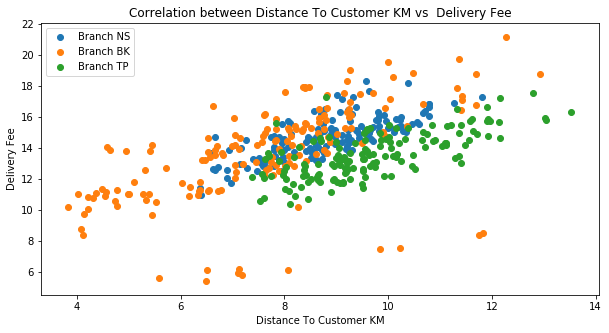

In [16]:
plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(NSOutlier['distance_to_customer_KM'], NSOutlier['delivery_fee'], label='Branch NS')
plt.scatter(BKOutlier['distance_to_customer_KM'], BKOutlier['delivery_fee'], label='Branch BK')
plt.scatter(TPOutlier['distance_to_customer_KM'], TPOutlier['delivery_fee'], label='Branch TP')
plt.legend()
plt.xlabel('Distance To Customer KM')
plt.ylabel('Delivery Fee')
plt.title('Correlation between Distance To Customer KM vs  Delivery Fee')

Using the corr function betweenn the two columns we can definitely say that some sort of positive correlation between them.

Then the above graph also helps us in visualising the correlation between `distance_to_customer_KM` and `delivery_fee` column for the respective `branch_codes`. 

We finally export the resultant outlier dataframe to a csv file. Below code does the same.

In [17]:
outlierData.to_csv('Group010_outlier_data_solution.csv', index = False)

As we have detected and removed the outliers, we move onto missing dataset.

# Missing Data

Since we have already loaded the data into dataframe, we now check which fields have the data missing.

In [18]:
missingData.isnull().sum()

order_id                     0
date                         0
time                         0
order_type                   0
branch_code                100
order_items                  0
order_price                  0
customer_lat                 0
customer_lon                 0
customerHasloyalty?          0
distance_to_customer_KM     50
delivery_fee                50
dtype: int64

The above code result states that there are 100 missing branch codes, 50 missing distance in terms of KM and 50 missing delivery fee. We handle each of them one by one.



In [19]:
# preliminary form of data analysis to check the content of the missingData dataframe
missingData.describe()

,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
count,500.000000,500.000000,500.000000,500.00000,450.000000,450.000000
mean,478.596600,-37.812275,144.966984,0.04200,8.640156,13.981347
std,263.583165,0.007548,0.020704,0.20079,1.569487,2.228607
min,28.500000,-37.827382,144.925244,0.00000,3.562000,4.499288
25%,274.500000,-37.818665,144.952520,0.00000,7.816250,12.895173
50%,427.725000,-37.812237,144.963677,0.00000,8.712500,14.081154
75%,634.850000,-37.806269,144.980778,0.00000,9.687500,15.385462
max,1335.000000,-37.794697,145.018679,1.00000,12.915000,19.135896


To fix the branch code, we use the branches file and compare the data with the outliers data.

### branch_code

This field represents the branch code in which the order was prepared. We need to make sure that all the entries in this column are in one of the mentioned branch codes.

In [20]:
# Checking the data in branches dataframe
branches

,branch_code,branch_name,branch_lat,branch_lon
0,NS,Nickolson,-37.773803,144.983647
1,TP,Thompson,-37.861835,144.905716
2,BK,Bakers,-37.815834,145.046450


In [21]:
# To see unique branch codes 
print('Unique branch codes in branches.csv file : ', branches['branch_code'].unique())

Unique branch codes in branches.csv file :  ['NS' 'TP' 'BK']


Based on the above code result, we see that there are three unique branch codes namely - NS, TP and BK. We need to make sure we have these branch codes only in our dirty dataset.

By looking at the input dataset of outliers data, we can find a relation between a subset of order id (subset of first 4 characters of order id) and branch code. Below is the code for the relationship between subset of order id and branch code.

In [22]:
#Setting the index 
index = 0

# Initializing branch order dictionary
branchOrderDict = {}

# Iterate through each row of order id column
for each in outlierData['order_id']:
    orderEach = each[0:4]                                                   # Extract subset of the order id
    if orderEach not in branchOrderDict.keys():
        branchOrderDict[orderEach] = outlierData['branch_code'][index]      # Create mapping between branch and subset of order id
    index += 1

# Display the dictionary
branchOrderDict

{'ORDX': 'BK',
 'ORDB': 'TP',
 'ORDY': 'TP',
 'ORDC': 'NS',
 'ORDI': 'NS',
 'ORDJ': 'TP',
 'ORDA': 'BK',
 'ORDK': 'BK',
 'ORDZ': 'NS'}

We see that in the outlier dataset, order id ending with 'X', 'A' and 'K' have branch code as 'BK', the order id ending with 'B', 'Y' and 'J' have branch code as 'TP and  the order id ending with 'C', 'I' and 'Z' have branch code as 'NS'.

We now check for the missing data and make sure we follow same pattern of the outliers dataset. Below is the code for the same.

In [23]:
#Setting the index 
index = 0

# Initializing branch order dictionary
branchOrderDictMissing = {}

# Iterate through each row of order id column
for each in missingData['order_id']:
    orderEach = each[0:4]                                                        # Extract subset of the order id
    if orderEach not in branchOrderDictMissing.keys():
        branchOrderDictMissing[orderEach] = missingData['branch_code'][index]    # Create mapping between branch and subset of order id
    index += 1

# Display the dictionary   
branchOrderDictMissing

{'ORDI': 'NS',
 'ORDA': 'BK',
 'ORDJ': 'TP',
 'ORDB': nan,
 'ORDY': nan,
 'ORDK': 'BK',
 'ORDZ': 'NS',
 'ORDX': nan,
 'ORDC': 'NS'}

The below code fixes the relationship between subset of order id and branch code for missing data.

In [24]:
# Setting the index
index = 0

# Iterate through each row in branch code column
for each in missingData['branch_code']:
    if pd.isnull(each):
        orderEach = missingData['order_id'][index][0:4]                            # Extract subset from order id
        missingData.at[index, 'branch_code'] = branchOrderDict.get(orderEach)      # Assigning the branch code to a particular order id subset
    index += 1

In [25]:
missingData.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDI04843,2018-11-13,18:28:43,Dinner,NS,"[('Pasta', 6), ('Salmon', 1), ('Shrimp', 7)]",584.0,-37.805108,144.977446,0,7.352,13.346627
1,ORDA04988,2018-01-25,08:40:33,Breakfast,BK,"[('Pancake', 8), ('Coffee', 4), ('Eggs', 10)]",444.0,-37.810363,145.009094,0,3.824,8.821264
2,ORDI06457,2018-01-08,08:10:08,Breakfast,NS,"[('Cereal', 4), ('Coffee', 7), ('Eggs', 10)]",356.5,-37.816576,144.980147,1,8.432,NaN
3,ORDJ04372,2018-05-14,12:23:39,Lunch,TP,"[('Fries', 2), ('Burger', 2), ('Salad', 7), ('...",366.4,-37.805830,144.956082,0,9.280,12.996916
4,ORDI05481,2018-05-14,12:23:39,Lunch,NS,"[('Fries', 9), ('Salad', 4), ('Chicken', 4), (...",808.8,-37.805830,144.956082,0,7.934,13.206729


In [26]:
# Setting the inex
index = 0

# Initilizing empty dictionary to capture branch and order id mapping
branchOrderDictMissing = {}

# Iterate through each row in order id column
for each in missingData['order_id']:
    orderEach = each[0:4]                                                        # Extract subset from order id
    if orderEach not in branchOrderDictMissing.keys():
        branchOrderDictMissing[orderEach] = missingData['branch_code'][index]    # Create mapping between order id and branch code
    index += 1

# Display the dictionary    
branchOrderDictMissing

{'ORDI': 'NS',
 'ORDA': 'BK',
 'ORDJ': 'TP',
 'ORDB': 'TP',
 'ORDY': 'TP',
 'ORDK': 'BK',
 'ORDZ': 'NS',
 'ORDX': 'BK',
 'ORDC': 'NS'}

We now see that the relationship between subset of order id and the branch code is in synch with that of the outlier dataset. With this, the null issue in the branch code column is fixed.

### distance_to_customer_KM

This field represents the shortest distance in KM between the branch and the customer nodes with respect to the nodes and edges input files provided. In order to find the shortest distance, we have used Dijkstra algorithm.

To find out the shortest distance, we have to refer to all the datasets (branches, nodes, edges and missing dataset). 

Since we have already loaded the data into dataframes, we simply apply algorithm to the dataset by manipulating the data we have. Firstly, we create a graph based on the edges data.

In [27]:
# To create a graph using edges from edges.csv file with weight as distance in meters
graph = nx.from_pandas_edgelist(edges,'u','v','distance(m)')

We then merge with branches and nodes dataframe based on the latitudes and longitues. Later, we drop the unrequired columns namely - branch_name, branch_lat, branch_lon, lat and lon.

In [28]:
# Merging branches and nodes based on latitudes and longtitudes
branchesNodes = pd.merge(branches, nodes, how = "left", left_on=["branch_lat", "branch_lon"], right_on=["lat", "lon"])

# Renaming 'node' column to 'branch_node' and dropping undesired columns ('branch_name', 'branch_lat', 'branch_lon', 'lat' and 'lon')
branchesNodes = branchesNodes.rename(columns={'node': 'branch_node'})
branchesNodes = branchesNodes.drop(["branch_name", "branch_lat", "branch_lon", "lat", "lon"], axis =1)

Having got the branches and their node, we find out the customer nodes. To do so, we merge the missingData with nodes dataframe and then remove the unrequired columns namely - lat and lon.

In [29]:
# Merging missing data and nodes based on latitudes and longtitudes
missingDataNodes = pd.merge(missingData, nodes, how = "left", left_on=["customer_lat", "customer_lon"], right_on=["lat", "lon"])

# Renaming 'node' column to 'customer_node' and dropping undesired columns ('lat' and 'lon')
missingDataNodes = missingDataNodes.rename(columns={'node': 'customer_node'})
missingDataNodes = missingDataNodes.drop(["lat", "lon"], axis = 1)

We finally merge the missing data with customer node and branch node details based on the branch_code. Below code does the same.

In [30]:
# Merging above dataframe with branchesNodes based on branch code 
mergedMissingData = pd.merge(missingDataNodes, branchesNodes, how = "left", on=["branch_code"])

We now calculate the shortest distance using dijkstra algorithm for the final dataframe formed above which consists of required data. Below code calculates the shortest distance in KM between the branch node and customer node.

In [31]:
# To check the number of missing entries in distance column
missingDistanceCount = 0

# Iterate through each row in the mergedMissingData dataframe
for index, row in mergedMissingData.iterrows():
    if pd.isnull(mergedMissingData.at[index, 'distance_to_customer_KM']):
        # Calculate the distance in terms of meters as per edges file
        distance = nx.shortest_path_length(graph, source = row['branch_node'], target = row['customer_node'], weight='distance(m)')
        
        # Converts the distance into KM by dividing with 1000
        distance = distance/1000
        
        # Increasing the eror count and correcting the distance
        missingDistanceCount += 1
        mergedMissingData.loc[index,'distance_to_customer_KM'] = distance
        
print('The number of missing entries filled with distance_to_customer_KM column : ', missingDistanceCount) 

The number of missing entries filled with distance_to_customer_KM column :  50


The above result matches with the number of the missing rows for the distance column in the missing data dataframe. Hence, we have successfully filled the missing distance values in the missing data dataframe. We now drop the customer and branch node from the missing data dataframe as we have to restore the original form of the missing data dataframe. Below code works for the same.

In [32]:
# Restoring the dataframe to original columns with correct data
missingData = mergedMissingData
missingData = missingData.drop(["customer_node", "branch_node"], axis =1)
missingData.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDI04843,2018-11-13,18:28:43,Dinner,NS,"[('Pasta', 6), ('Salmon', 1), ('Shrimp', 7)]",584.0,-37.805108,144.977446,0,7.352,13.346627
1,ORDA04988,2018-01-25,08:40:33,Breakfast,BK,"[('Pancake', 8), ('Coffee', 4), ('Eggs', 10)]",444.0,-37.810363,145.009094,0,3.824,8.821264
2,ORDI06457,2018-01-08,08:10:08,Breakfast,NS,"[('Cereal', 4), ('Coffee', 7), ('Eggs', 10)]",356.5,-37.816576,144.980147,1,8.432,NaN
3,ORDJ04372,2018-05-14,12:23:39,Lunch,TP,"[('Fries', 2), ('Burger', 2), ('Salad', 7), ('...",366.4,-37.805830,144.956082,0,9.280,12.996916
4,ORDI05481,2018-05-14,12:23:39,Lunch,NS,"[('Fries', 9), ('Salad', 4), ('Chicken', 4), (...",808.8,-37.805830,144.956082,0,7.934,13.206729


In [33]:
missingData.isnull().sum()

order_id                    0
date                        0
time                        0
order_type                  0
branch_code                 0
order_items                 0
order_price                 0
customer_lat                0
customer_lon                0
customerHasloyalty?         0
distance_to_customer_KM     0
delivery_fee               50
dtype: int64

### delivery_fee

Now that we have fixed, the missing branch code and distance, the only thing left is to impute is the delivery fee. To do so, we need to predict the data based on the weekday/weekend, time of the day and distance between branch and customer nodes. Also, we need to segregate the data based on the branch code as delivery fees is dependent on branch code as well. Since the predictors are dependent linearly, we use linear regression method to predict the delivery fees information.

Firstly, we create new columns namely 'weekday_or_weekend' and 'time_of_day' into the missing data dataframe. The column 'weekday_or_weekend' represents if the day on which order was placed was a weekday or weekend whereas the column 'time_of_day' represents at what time the order was placed - morning(0), afternoon(1) or evening(2). We then split the data based on the branch code.

In [34]:
# Missing Data

# Setting 0 to weekday and 1 to weekend
missingData['weekday_or_weekend'] = pd.to_datetime(missingData['date']).dt.weekday
missingData['weekday_or_weekend'] = missingData['weekday_or_weekend'].apply(lambda x: 0 if int(x)< 5 else 1)

# Setting 0 breakfast, 1 for lunch and 2 for dinner
missingData['time_of_day'] = missingData['order_type'].apply(lambda x: 0 if x=='Breakfast' else (1 if x=='Lunch' else 2))

# Segregating based on branch code
NSMissing = missingData.loc[missingData['branch_code'] == 'NS']
BKMissing = missingData.loc[missingData['branch_code'] == 'BK']
TPMissing = missingData.loc[missingData['branch_code'] == 'TP']

Since we have considered the outliers data as reference dataset, we rely on this data and the missing data excluding nulls to predict the delivery fee for the missing data dataset. Also, the more data points we have, better the model training result. Considering only the missing data excluding nulls to predeict the missing data with nulls might introduce bias. Also, we cannot use dirty data information as the data is cluttered. Hence we rely on the combination of the outliers and missing data (excluding nulls) information to predict the missing delivery fees.

We now create the 'weekday_or_weekend' and 'time_of_day' columns for outlier data. Later, we segregate the data based on the branch code. The idea is to create similar columns in both processed outliers and missing data dataset (excluding nulls), fit the data in the linear model and predict the data missing delivery fee. Below is the code for the same.

In [35]:
# Setting 0 to weekday and 1 to weekend
outlierData['weekday_or_weekend'] = pd.to_datetime(outlierData['date']).dt.weekday
outlierData['weekday_or_weekend'] = outlierData['weekday_or_weekend'].apply(lambda x: 0 if int(x)< 5 else 1)

# Setting 0 breakfast, 1 for lunch and 2 for dinner
outlierData['time_of_day'] = outlierData['order_type'].apply(lambda x: 0 if x=='Breakfast' else (1 if x=='Lunch' else 2))

# Segregating based on branch code
NSOutlier = outlierData.loc[outlierData['branch_code'] == 'NS']
BKOutlier = outlierData.loc[outlierData['branch_code'] == 'BK']
TPOutlier = outlierData.loc[outlierData['branch_code'] == 'TP']

Now that we have outliers data ready, we split the missing data set further into missing data with nulls and without nulls based on the branch code.

In [36]:
# Segregating missing data with nulls based n branch code
NSMissingNull = NSMissing[NSMissing['delivery_fee'].isnull()]
BKMissingNull = BKMissing[BKMissing['delivery_fee'].isnull()]
TPMissingNull = TPMissing[TPMissing['delivery_fee'].isnull()]

# Segregating missing data without nulls based n branch code
NSMissingNotNull = NSMissing[NSMissing['delivery_fee'].notnull()]
BKMissingNotNull = BKMissing[BKMissing['delivery_fee'].notnull()]
TPMissingNotNull = TPMissing[TPMissing['delivery_fee'].notnull()]

Here, we combine the outliers and missing data (excluding nulls) based on the branch code. The data is now ready to be trained for the linear model. We have to split the data further by picking the required columns (the ones which have linear dependency - discussed further).

In [37]:
NSCombined = NSOutlier.append(NSMissingNotNull, ignore_index=True)
BKCombined = BKOutlier.append(BKMissingNotNull, ignore_index=True)
TPCombined = TPOutlier.append(TPMissingNotNull, ignore_index=True)

In [38]:
# Linear Model for branch code NS (missing data)
lmForImputeNS = LinearRegression()

# Linear Model for branch code BK (missing data)
lmForImputeBK = LinearRegression()

# Linear Model for branch code TP (missing data)
lmForImputeTP = LinearRegression()

We now train the model with the segregated data points. As per the specifications, the fields 'weekday_or_weekend', 'time_of_day', 'distance_to_customer_KM' and 'customerHasloyalty?' are linearly dependent on the delivery fees. Hence, we feed the relevant predictors as Xtrain and the delivery fee as Ytrain to the linear model while the predictors of the missing dataset for the missing dataset with nulls are fed as test data to the model in order to predict its delivery fees.

In [39]:
# Training and Testing data for branch code NS 
NSXtrain = NSCombined[['weekday_or_weekend','time_of_day','distance_to_customer_KM', 'customerHasloyalty?']]
NSYtrain = NSCombined[['delivery_fee']]
NStest = NSMissingNull[['weekday_or_weekend','time_of_day','distance_to_customer_KM', 'customerHasloyalty?']]

# Training and Testing data for branch code BK
BKXtrain = BKCombined[['weekday_or_weekend','time_of_day','distance_to_customer_KM', 'customerHasloyalty?']]
BKYtrain = BKCombined[['delivery_fee']]
BKtest = BKMissingNull[['weekday_or_weekend','time_of_day','distance_to_customer_KM', 'customerHasloyalty?']]

# Training and Testing data for branch code TP
TPXtrain = TPCombined[['weekday_or_weekend','time_of_day','distance_to_customer_KM', 'customerHasloyalty?']]
TPYtrain = TPCombined[['delivery_fee']]
TPtest = TPMissingNull[['weekday_or_weekend','time_of_day','distance_to_customer_KM', 'customerHasloyalty?']]

Before predicting the data directly, we have to fit the model with the relevant data and then check for the score (r squared value). This score represents how well the data is fit to the model used - higher the value, better the fit. However, high value doesn't always mean that the fit is prefect. If we see high r squared value, it may also mean that the prediction is in line with the current datapoints but we might see variance for a new data points taken from the same sample which have different range from that of the previous datapoints used. Hence, too low or too high r-squared values are also not good for the model.

In [40]:
# Fit the model and calculate R score for branch code NS 
lmForImputeNS = lmForImputeNS.fit(NSXtrain,NSYtrain)
print('R squared value for data with branch code NS = ', lmForImputeNS.score(NSXtrain,NSYtrain))

# Fit the model and calculate R score for branch code BK
lmForImputeBK = lmForImputeBK.fit(BKXtrain,BKYtrain)
print('R squared value for data with branch code BK = ', lmForImputeBK.score(BKXtrain,BKYtrain))

# Fit the model and calculate R score for branch code TP
lmForImputeTP = lmForImputeTP.fit(TPXtrain,TPYtrain)
print('R squared value for data with branch code TP = ', lmForImputeTP.score(TPXtrain,TPYtrain))

R squared value for data with branch code NS =  0.9680085251081013
R squared value for data with branch code BK =  0.9037737844069839
R squared value for data with branch code TP =  0.891565061714666


As we see that the r squared values are pretty high enough to consider for this model, we proceed with the prediction and impute the missing values.

In [41]:
# Predict the missing delivery fees for data points with branch code NS and impute values
predicted = lmForImputeNS.predict(NStest)
count = 0
for index, row in NSMissingNull.iterrows():
    if (math.isnan(row['delivery_fee'])):
        NSMissingNull.at[index,'delivery_fee'] = predicted[count][0]
        count += 1
        
# Predict the missing delivery fees for data points with branch code BK and impute values
predicted = lmForImputeBK.predict(BKtest)
count = 0
for index, row in BKMissingNull.iterrows():
    if (math.isnan(row['delivery_fee'])):
        BKMissingNull.at[index,'delivery_fee'] = predicted[count][0]
        count += 1

# Predict the missing delivery fees for data points with branch code TP and impute values
predicted = lmForImputeTP.predict(TPtest)
count = 0
for index, row in TPMissingNull.iterrows():
    if (math.isnan(row['delivery_fee'])):
        TPMissingNull.at[index,'delivery_fee'] = predicted[count][0]
        count += 1  

Now that we have imputed the missing delivery fee values, we recombine the datapoints that we have split earlier based on the branch code to form one whole missing dataset.

In [42]:
# Combining the missing data (with nulls and without nulls) based on each branch
NSMissing = NSMissingNull.append(NSMissingNotNull, ignore_index=True)
BKMissing = BKMissingNull.append(BKMissingNotNull, ignore_index=True)
TPMissing = TPMissingNull.append(TPMissingNotNull, ignore_index=True)

# Combining the data points for all the branches and creating one dataframe
NSBKMissing = NSMissing.append(BKMissing, ignore_index=True)
missingDataSolution = NSBKMissing.append(TPMissing, ignore_index=True)

# Dropping the unrequired data columns
missingDataSolution = missingDataSolution.drop(columns=['weekday_or_weekend', 'time_of_day'])

In [43]:
missingDataSolution.isnull().sum()

order_id                   0
date                       0
time                       0
order_type                 0
branch_code                0
order_items                0
order_price                0
customer_lat               0
customer_lon               0
customerHasloyalty?        0
distance_to_customer_KM    0
delivery_fee               0
dtype: int64

In the above code result, we can see that there are finally no nulls in the missing dataset. This implies that all the nulls have been handled. Before moving onto the next segment, we export the missing data into a csv file.

In [44]:
missingDataSolution.to_csv('Group010_missing_data_solution.csv', index = False)

# Dirty Data

As per the specifications, there is atmost one anomaly in each row in this dataset. We pick each column and analyse the data. Firstly, we check if there are any duplicates in the dataset. If there are any, we remove them or else proceed with the current dataset.

In [45]:
# Printing the dimension of the original dataframe
print('Dimension of the original dataframe : ', dirtyData.shape)

# Let's drop duplicates and make sure there are unique rows in our dataframe
print('Dimension of the dataframe after dropping duplicates : ', dirtyData.drop_duplicates().shape)

Dimension of the original dataframe :  (500, 12)
Dimension of the dataframe after dropping duplicates :  (500, 12)


As we have same number of columns before and after dropping the duplicates, we can proceed with the original dataframe for our operations. Let's check for the columns of the dataframe and then pick each column, analyse the data and fix errors, if any.

In [46]:
# preliminary form of data analysis to check the content of the dirtyData dataframe
dirtyData.describe()

,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,495.080300,-30.753910,143.504305,0.128000,8.615828,13.525012
std,264.227147,25.336381,16.299228,0.334424,1.654765,2.653907
min,29.500000,-37.829895,-37.821798,0.000000,3.634000,4.827132
25%,294.250000,-37.818171,144.951479,0.000000,7.690000,12.187645
50%,444.000000,-37.811813,144.963948,0.000000,8.767000,13.748074
75%,638.375000,-37.803990,144.981148,0.000000,9.711000,15.232637
max,1394.000000,144.992130,145.019342,1.000000,13.202000,20.145842


In [47]:
dirtyData.columns

Index(['order_id', 'date', 'time', 'order_type', 'branch_code', 'order_items',
       'order_price', 'customer_lat', 'customer_lon', 'customerHasloyalty?',
       'distance_to_customer_KM', 'delivery_fee'],
      dtype='object')

### order_id

The order_id column should have unique values. The below code checks for the same. We use negation technique (using 'not' in if condition). If there are no duplicates in the order id, 'if' segment is executed and if there are any duplicates, 'else' segment is executed.

In [48]:
#  To check if order_id is unique
if not any(dirtyData['order_id'].duplicated()):                      # not False implies that there are no duplicates
    print('There are no duplicate order ids in the dataframe.')  
else:
    print('There are duplicate order ids in the dataframe.')

There are no duplicate order ids in the dataframe.


As there are no duplicates in the order id, we can proceed to next column inspection.


### date

The date column should be in the format 'yyyy-mm-dd'. As per the results obtained above, it appears that the date column has various date formats which are 'yyyy-mm-dd', 'mm-dd-yyyy', 'yyyy-dd-mm' and 'dd-mm-yyyy'. We need to compare each field in the date column with the formats mentioned earlier and convert if the date format is any different from the required format.

In [49]:
formats = ['%Y-%m-%d', '%d-%m-%Y', '%m-%d-%Y', '%Y-%d-%m']         # Formats to try
resultFormat = '%Y-%m-%d'                                          # Desired format

# Setting the index
index = 0

# To check the number of entries with undesired date format
dateErrorList = []

for eachDate in dirtyData['date']:                                 # Iterate through each field in the date column
    formatFlag = False                                             # Setting flag for date format
    for eachFormat in formats:                                     # Iterate through each date format for comparison
        if formatFlag:
            break
        try:
            dateFormat = datetime.strptime(eachDate, eachFormat)   # Try the format
            outputDate = dateFormat.strftime(resultFormat)         # Remove time from the resultant datetime format
            formatFlag = True
        except ValueError:
            dateErrorList.append(index)                            # Append the index of the rows with wrong entry
    dirtyData.at[index, 'date'] = outputDate                       # Replace the entry with changed date format
    index += 1                                                     # Increment the index to keep up with the loop and to replace the entry with changed date format

# Since it is trying each format, there will be multiple entries in dateErrorList.
# Hence, we change the list into set and back to list again
dateErrorList = list(set(dateErrorList))

# Sorting the error list
dateErrorList.sort()

# Printing the number of corrected entries in date column    
print('The number of entries corrected in the date column : ', len(dateErrorList))  

The number of entries corrected in the date column :  37


It can be seen in the above code result that there are 37 number of incorrect entries for the date column. We now convert the datatype of this column and verify the same using the dtypes functionality of pandas.

In [50]:
# Convert the values in date column to datetime datatype
dirtyData['date'] =  pd.to_datetime(dirtyData['date'], format='%Y-%m-%d')

In [51]:
# To check if the changes reflect date time data type
dirtyData.dtypes

order_id                           object
date                       datetime64[ns]
time                               object
order_type                         object
branch_code                        object
order_items                        object
order_price                       float64
customer_lat                      float64
customer_lon                      float64
customerHasloyalty?                 int64
distance_to_customer_KM           float64
delivery_fee                      float64
dtype: object

As we can see that the date column has been changed to datetime datatype, we can now move onto the next column.

### time

This column represents the time the order was prepared and is given by hh:mm:ss format. We need to check if this column is in the given format.

In [52]:
dirtyData['time']

0      10:42:15
1      10:32:06
2      16:47:19
3      17:07:36
4      17:38:01
5      13:14:21
6      15:46:28
7      10:32:06
8      13:44:47
9      14:55:46
10     10:42:15
11     15:46:28
12     14:55:46
13     10:21:58
14     13:14:21
15     12:43:56
16     10:52:23
17     08:10:08
18     14:35:29
19     19:09:17
20     09:51:32
21     10:21:58
22     15:46:28
23     13:04:13
24     11:32:57
25     08:10:08
26     13:14:21
27     11:53:14
28     15:56:37
29     14:05:04
         ...   
470    08:50:42
471    08:50:42
472    14:55:46
473    10:01:41
474    08:00:00
475    19:29:34
476    09:31:16
477    09:21:07
478    19:49:51
479    13:24:30
480    18:08:27
481    20:00:00
482    13:24:30
483    18:59:09
484    08:00:00
485    18:59:09
486    10:01:41
487    20:00:00
488    08:50:42
489    16:27:02
490    15:26:11
491    08:10:08
492    11:12:40
493    08:20:16
494    18:08:27
495    09:10:59
496    12:54:05
497    08:00:00
498    08:50:42
499    11:43:05
Name: time, Length: 500,

In [53]:
dirtyData['time'].min()

'08:00:00'

In [54]:
dirtyData['time'].max()

'20:00:00'

In the dirty data input file, we noticed that the format was in the form 'hh:mm:ss' or 'h:mm:ss' but when we load the csv data into pandas dataframe, it automatically stored the values in 'hh:mm:ss' format. Also the minimum and maximum time are 8am and 8pm respectively. Hence, the values in the time column seems fine. No alteration is required.

### order_type

This field represents different types of orders namely 'Breakfast', 'Lunch' and 'Dinner'. We need to make sure that these three meal types are served in the allotted time slots. For this, we can use a method to check the timing and return the supposed meal type.

In [55]:
# Setting time limits for breakfast and lunch 
breakfastStartTime = datetime.strptime('08:00:00', "%H:%M:%S")
breakfastEndTime = datetime.strptime('12:00:00', "%H:%M:%S")
lunchStartTime = datetime.strptime('12:00:01', "%H:%M:%S")
lunchEndTime = datetime.strptime('16:00:00', "%H:%M:%S")

# Method to check the order type 
def timeCheck(orderTime):
    orderTime = datetime.strptime(orderTime, "%H:%M:%S")     # Converts text into datetime format
    if breakfastStartTime <= orderTime <= breakfastEndTime:
        return 'Breakfast'                                   # Returns Breakfast if order time falls under breakfast time window
    elif lunchStartTime <= orderTime <= lunchEndTime:
        return 'Lunch'                                       # Returns Lunch if order time falls under lunch time window
    else:
        return 'Dinner'                                      # Returns Dinner if order time doesn't falls under breakfast or lunch time window

Whenever there's a mismatch of the data in the order_type column, we replace the wrong order type with the correct order type and append the index of that row to the orderTypeErrorList.

In [56]:
# Setting the index
index = 0    

# To check the number of wrong entries in order_type column
orderTypeErrorList = []

# Iterate through each field in time column
for eachTime in dirtyData['time']:
    orderType = timeCheck(eachTime)                          # Pass each element in the time column to timeCheck function to determine the order type
    if dirtyData['order_type'][index] != orderType:          # Checks if there's a mismatch between existing and expected order type
        dirtyData.at[index, 'order_type'] = orderType        # Replace the expected order type with existing order type in the dataframe in case of mismatch
        orderTypeErrorList.append(index)                     # Append the index of the rows with wrong entry
    index += 1                                               # Increment the index for next iteration

orderTypeErrorList.sort()                                    # Sorting the error list

# Printing the number of corrected entries in branch code column
print('The number of entries corrected in order_type column : ', len(orderTypeErrorList))    

The number of entries corrected in order_type column :  37


### branch_code

This field represents the branch code in which the order of the customer was made. For this, we need to refer the branches.csv file and make sure that correct branch code is assigned. Further, using the outliers data as the reference, we find out the mapping between the subset of the order id and the branch code (similar to the process in the case of missing data analysis).

In [57]:
print('Unique branch codes in branches.csv file : ', branches['branch_code'].unique())
print('Unique branch codes in branch_code column (in Group010_dirty_data.csv) before changes : ', dirtyData['branch_code'].unique())

Unique branch codes in branches.csv file :  ['NS' 'TP' 'BK']
Unique branch codes in branch_code column (in Group010_dirty_data.csv) before changes :  ['tp' 'NS' 'TP' 'BK' 'ns' 'bk']


We see that there is an issue in the case of the branch codes in the dataframe. We can simply convert each field into upper case to resolve this issue and make sure that the data meets assignment specifications.

In [58]:
# Setting the index
index = 0

# To check the number of wrong branch code entries
branchErrorList = []

# Iterate through each code in branch_code column
for eachCode in dirtyData['branch_code']:
    if not eachCode.isupper():
        dirtyData.at[index, 'branch_code'] = eachCode.upper()        # If the existing branch_code is in lower case, replace with the upper case
        branchErrorList.append(index)                                # Append the index of the wrong entry to error list
    index += 1

# Sorting the error list
branchErrorList.sort()

# Printing the number of corrected entries in branch code column
print('The number of entries corrected in branch_code column : ', len(branchErrorList))
    
# Check if the above case change was implemented successfully
print('Unique branch codes in branch_code column after changes : ', dirtyData['branch_code'].unique())

The number of entries corrected in branch_code column :  25
Unique branch codes in branch_code column after changes :  ['TP' 'NS' 'BK']


Although the above fix is applied, mapping between the subset of order id and the branch code still is a point of concern. Below code snippets take care of that issue. We now create a dictionary with the order subset and branch code mapping for the dirty data and compare the same with the outlier's dictionary and make corresponding changes.

In [59]:
# Setting the index
index = 0

# Initializing an empty dictionary to store order id and branch code mapping
branchOrderDictDirty = {}

# Itterate through each row of the order id column from dirty data
for each in dirtyData['order_id']:
    orderEach = each[0:4]                                                    # Extracting the subset of the order id
    if orderEach not in branchOrderDictDirty.keys():
        branchOrderDictDirty[orderEach] = dirtyData['branch_code'][index]    # Creating order id and branch code mapping
    index += 1
    
branchOrderDictDirty

{'ORDB': 'TP',
 'ORDC': 'NS',
 'ORDK': 'BK',
 'ORDY': 'TP',
 'ORDX': 'BK',
 'ORDZ': 'NS',
 'ORDJ': 'TP',
 'ORDA': 'TP',
 'ORDI': 'NS'}

In [60]:
# Setting the index
index = 0

# Iterating through each field of the branch code from dirty data
for each in dirtyData['branch_code']:
    orderEach = dirtyData['order_id'][index][0:4]                                # Extracting subset of order id
    if branchOrderDict.get(orderEach) != dirtyData.at[index, 'branch_code']:
        dirtyData.at[index, 'branch_code'] = branchOrderDict.get(orderEach)      # Fixing the misplacement of the branch code
        branchErrorList.append(index)                                            # Maintaining the error list
    index += 1

# Since we are checking the branch codes twice (one for case and other based on mapping), we change the list into set and back to list again
branchErrorList = list(set(branchErrorList))
branchErrorList.sort()

# Printing total number of wrong entries for branch code
print('The overall entries affected based on branch code : ', len(branchErrorList))

The overall entries affected based on branch code :  37


### order_price and order_items

The order price represents total price as a floating point. Before we analyse and fix the order items column, we need to figure out the price of each item that is present in the order. For this, we need to refer the outlier dataset, get the mappings and calculations done and finally fix the order items column.

In [61]:
# Setting the index
index = 0   

# creating separate lists of items served based on breakfast, lunch and dinner
breakfastList = []
lunchList = []
dinnerList = []

# Iterate through each field of order items from outlier data
for each in outlierData['order_items']:
    value = eval(each)                                               
    if outlierData['order_type'][index] == "Breakfast":     
        for eachVal in value:                               # looping through the items in order_items
            breakfastList.append(eachVal[0])                # appending the item name into the breakfast list
    elif outlierData['order_type'][index] == "Lunch":
        for eachVal in value:                               # looping through the items in order_items
            lunchList.append(eachVal[0])                    # appending the item name into the lunch list
    else:
        for eachVal in value:                               # looping through the items in order_items
            dinnerList.append(eachVal[0])                   # appending the item name into the dinner list
    index += 1   

# removing duplicates using set and then converting it back into a list.
breakfastList = list(set(breakfastList))
lunchList = list(set(lunchList))
dinnerList = list(set(dinnerList))

In [62]:
# Initializing a full list to store all meals information 
fullList = []
fullList.extend(breakfastList)
fullList.extend(lunchList)
fullList.extend(dinnerList)

# Initializing empty dictionary to create mapping of each item with a number for further analysis
fullDict = {}
for i in range(len(fullList)):
    fullDict[i] = fullList[i]

# Printing the dictionary for reference
print(fullDict)

{0: 'Pancake', 1: 'Cereal', 2: 'Eggs', 3: 'Coffee', 4: 'Steak', 5: 'Fries', 6: 'Salad', 7: 'Chicken', 8: 'Burger', 9: 'Shrimp', 10: 'Pasta', 11: 'Fish&Chips', 12: 'Salmon'}


Here, we store the order item in form of a dictionary with a number associated with it for easy reference in further analysis.

In [63]:
# Setting the index 
index = 0

# Initializing empty lists to store order price and total count list
orderPriceList = []
totalCountList = []

# Iterate through each field of order items from outlier data
for items in outlierData['order_items']:
    allItems = eval(items)
    countList = []
    
    # Iterate through each key and value from the full items dictionary
    for key, value in fullDict.items():
        count = 0                                              # Here, count acts as a flag
        for item in allItems:
            if item[0] == value:
                countList.append(item[1])                      # If the value matches, append the item quantity to the count list
                count = 1
        if count != 1:
            countList.append(0)                                # If the value is not in the order item, append 0 to the count list
            
    totalCountList.append(countList)                           # Append the count list to the total count list
    orderPriceList.append(outlierData['order_price'][index])   # Append the order price in sequence into order price list
    
    index += 1

In the above code segment we are creating seperate matrices which we are going to use for the purpose of calculating linear equations. The totalCountList contains the coefficient values, which we are generating using the full items dictionary, and setting the values accordingly like in the form of a matrix. The orderPriceList contains the price of the total order, which we get from the 'order_price' column, for each index appended into a list.

In [64]:
# To show the list of lists created from above step
totalCountList

[[0, 0, 0, 0, 4, 10, 6, 1, 2, 0, 0, 0, 0],
 [0, 0, 0, 0, 7, 6, 9, 9, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 1, 0],
 [1, 2, 4, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 3, 0, 3, 1, 3, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 7, 8, 7],
 [0, 4, 8, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [8, 0, 3, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 6, 2, 1, 0, 10, 0, 0, 0, 0],
 [10, 7, 10, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 8, 5, 6, 5, 8, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 4, 0],
 [6, 8, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 0],
 [9, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 3, 5, 0, 4, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 4, 0, 3, 8, 7, 0, 0, 0, 0],
 [0, 0, 0, 0, 5, 2, 6, 3, 4, 0, 0, 0, 0],
 [0, 0, 0, 0, 8, 0, 9, 10, 6, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 9, 7],
 [0, 0, 0, 0, 3, 9, 2, 0, 0, 0, 0, 0, 0],
 [0, 9, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 2, 9, 0, 0, 0, 

We will use the lstsq function of np.linalg library to solve the set of linear equations and compute the unit prices for all the items served in the restaurant. The function lstsq returns the solution, residual, rank and singular value arrays. Since we need prices for further calculations, we store the array into a variable and use it upcoming steps.

In [65]:
# Converting the totalCountList into numpy array
totalCountArray = np.array(totalCountList)

# Converting the orderPriceList into numpy array
orderPriceArray = np.array(orderPriceList)

# Solving the linear system of equations using lstsq functionality of numpy
prices, residuals, rank, singularValues = np.linalg.lstsq(totalCountArray, orderPriceArray, rcond=None)

Here, we map each item with it's unit price for further computation.

In [66]:
# Initializing the item price dictionary
itemPriceDict = {}

# Assigning the item price to item as key
for key, value in fullDict.items():
    itemPriceDict[value] = round(prices[key],2)

# Printing the dictionary to check the assigned values
itemPriceDict

{'Pancake': 24.25,
 'Cereal': 21.0,
 'Eggs': 22.0,
 'Coffee': 7.5,
 'Steak': 45.0,
 'Fries': 12.0,
 'Salad': 17.2,
 'Chicken': 32.0,
 'Burger': 31.0,
 'Shrimp': 54.0,
 'Pasta': 27.5,
 'Fish&Chips': 35.0,
 'Salmon': 41.0}

All the above data generated is based on clean outlier data as it has correct data. So, now we will be fixing the errors in 'order_price' and 'order_items' column for dirty data.

Below we have created a function which helps us to replace the wrong item with the correct item and it's corresponding quantity. To this function we are passing the list after removing the wrong item, then breakfast, lunch or dinner lists as itemList and also the index, where the error exists. The function in the end returns the corrected version of the list with the correct items.

In [67]:
def finalOrderItemList(tempList, itemList, index):
    sumVal = 0 
    for temp in tempList:
        itemPattern = re.search(r"'(.*?)'", temp)                                 # Search for the item name
        itemVal = itemPattern.group(1).strip()
        valuePattern = re.search(r",(.*?)\)", temp)                               # Search for the item quantity
        numVal = int(valuePattern.group(1).strip())
        productValue = 0
        productValue = itemPriceDict.get(itemVal) * numVal                        # Calculate price of each item (item value x quantity)
        sumVal += productValue                                                    # Calculate the sum of prices of all items
    origOrderPrice = dirtyData['order_price'][index]                              # Storing original order price
    if round(sumVal, 2) != round(dirtyData['order_price'][index], 2):
        diffVal = origOrderPrice - sumVal                                         # Calculating the difference between calculated order price and original order price 
        for ordItems in itemList:
            outputVal = round(diffVal,2) / round(itemPriceDict.get(ordItems),2)
            if outputVal.is_integer():                                           # Checking if the value is an integer or not.
                outputStr = ""                                                   # Initializing empty string to store order items and quantity
                outputStr = "('" + ordItems + "', " + str(int(outputVal)) + ")"  # Creating a string with the item name and its respective quantity.
                tempList.append(outputStr)                                       # Appending the formatted string
      
    # Returning the final list which contains the correct set of items
    return tempList

In [68]:
# Setting the index 
index = 0   

# Initializing empty list to store the indexes where we get an error in order items
orderItemsErrorList = []

# Iterate through each field of order items from outlier data
for items in dirtyData['order_items']:
    text = re.compile(r"'(.*?)'")                                  # Compiling and storing the pattern to extract the items 
    value = text.findall(items)                                    # Extracting all the instances of that pattern
    tempList = []                                                  # Creating an empty list 
    
    # Executing the contents inside the if-elif-else condition based on the order_type
    if dirtyData['order_type'][index] == "Breakfast":
        for each in value:                                         # Iterating through all the items in the extracted list
            if each not in breakfastList:                          # Checking if any of the items is not in the breakfast list.
                allItems = re.findall('(\(([^)]+)\))', items)      # Finding all the patterns matching with the name of each item
                for i in range(len(allItems)):
                    if each not in allItems[i][0]:
                        tempList.append(allItems[i][0])            # Creating a new list only based on the items present in the breakfast list
                seperator = ', '      
                dirtyData.at[index, 'order_items'] = '[' + seperator.join(finalOrderItemList(tempList, breakfastList, index)) + ']'  # finally putting the values back to its particular index.

                orderItemsErrorList.append(index) 
    # For lunch            
    elif dirtyData['order_type'][index] == "Lunch":
        for each in value:                                         # Iterating through all the items in the extracted list
            if each not in lunchList:                              # Checking if any of the items is not in the lunch list.
                allItems = re.findall('(\(([^)]+)\))', items)      # Finding all the patterns matching with the name of each item
                for i in range(len(allItems)):
                    if each not in allItems[i][0]:
                        tempList.append(allItems[i][0])            # Creating a new list only based on the items present in the lunch list
                seperator = ', ' 
                dirtyData.at[index, 'order_items'] = '[' + seperator.join(finalOrderItemList(tempList, lunchList, index)) + ']'  # finally putting the values back to its particular index.
                orderItemsErrorList.append(index)
    # For Dinner            
    else:
        for each in value:                                         # Iterating through all the items in the extracted list
            if each not in dinnerList:                             # Checking if any of the items is not in the dinner list.
                allItems = re.findall('(\(([^)]+)\))', items)      # Finding all the patterns matching with the name of each item
                for i in range(len(allItems)):
                    if each not in allItems[i][0]:
                        tempList.append(allItems[i][0])            # Creating a new list only based on the items present in the dinner list
                seperator = ', '  
                dirtyData.at[index, 'order_items'] = '[' + seperator.join(finalOrderItemList(tempList, dinnerList, index)) + ']'  # finally putting the values back to its particular index.
                orderItemsErrorList.append(index)
    index += 1   

# Sorting the error list
orderItemsErrorList.sort()

# Printing total number of wrong entries for order items
print('The overall entries affected based on order items : ', len(orderItemsErrorList))

The overall entries affected based on order items :  37


In the above segment, we are first extracting out all the items along with its quantity values from the 'order_items' column and then checking if the ordered items are actually a part of their respective order types or not. If the item is not a part of its respective order type then that item along with its quantity is removed from that index.

Note: We are removing the invalid items from 'order_items' because it is not a part of that particular 'order_type'.

In [69]:
# Setting the index 
index = 0

# Initializing empty list to store the indexes where we get an error in order items
dirtyOrderPriceErrorList = []

# Iterate through each field of order items from outlier data
for items in dirtyData['order_items']:
    allItems = eval(items)                                      # Converting the row into a list of tuples having the name of the item and its ordered quantity.
    sumValue = 0                                                # Setting it to '0' as we will be recalculating for all the rows.

    for each in allItems:                                       # Iterating through all the extracted items
        productValue = 0
        productValue = itemPriceDict.get(each[0]) * int(each[1])     # Multiplying the item quantity with its unit price.
        sumValue += productValue                                     # Adding up all the values to get the total order price.
        
    if round(sumValue, 2) != round(dirtyData['order_price'][index], 2):     # If the order values is not equal to the calculated value then we are correcting the prder price value
        dirtyData.at[index, 'order_price'] = sumValue
        dirtyOrderPriceErrorList.append(index)   
    index += 1

# Sorting the error list
dirtyOrderPriceErrorList.sort()   
    
# Printing total number of wrong entries for order price
print('The overall entries affected based on order price : ', len(dirtyOrderPriceErrorList))    

The overall entries affected based on order price :  37


In the above segment we are simply multiplying the quantity of the items with its unit price, summing them all up and comparing the total value with the 'order_price' value at that particular index. We are rectifying the 'order_price' value based on that.

### customer_lat and customer_lon

customer_lat and customer_lon are fields which represent the latitude and longitude of the customer coming from 'nodes.csv'. We have to make sure that the entries in the dirty data csv file are in synch with the data in nodes file.

In [70]:
# Displaying first few rows of nodes dataframe
nodes.head()

,node,lat,lon
0,711327755,-37.807675,144.955873
1,711327756,-37.807094,144.955978
2,711327759,-37.807301,144.957817
3,711327760,-37.807885,144.957719
4,777781264,-37.805221,144.952173


In [71]:
# Displaying the minimum values of both latitude and longitude
nodes[['lat','lon']].min()

lat    -38.110916
lon    144.654173
dtype: float64

In [72]:
# Displaying the minimum values of both latitude and longitude
nodes[['lat','lon']].max()

lat    -37.739636
lon    145.046450
dtype: float64

It seems that the latitude values are close to -37 whereas longitude values are close to 144. The same can be verified by checking the dirty data csv file provided. The below code checks the above mentioned assumption programatically.

In [73]:
# Setting latitude count to 0 
latitudeCount = 0

for eachLatitude in nodes['lat']:
    if eachLatitude < -37:
        latitudeCount += 1                # To check as for how many values are less than -37

# Setting longitude count to 0        
longitudeCount = 0

for eachLatitude in nodes['lon']:
    if eachLatitude > 144:
        longitudeCount += 1               # To check as for how many values are greater than 144

# To check if above values match total number of rows in the nodes file
if latitudeCount == longitudeCount == len(nodes):
    print('The value for latitudes is in negative(close to -37) while the value for longitudes is in positive(above 144).')
else:
    print('The values for latitudes and longitudes in nodes.csv file are varying!')

The value for latitudes is in negative(close to -37) while the value for longitudes is in positive(above 144).


After having it verified programitically, it seems that the latitude values are close to -37 whereas longitude values are close to 144 throughout the nodes.csv file. Now, let's check for errors in the data entry in the 'customer_lat' and 'customer_lon' columns of dirty data csv file.

In [74]:
# Setting latitude count to 0 
latitudeCount = 0

for eachLatitude in dirtyData['customer_lat']:
    if eachLatitude < -37:
        latitudeCount += 1                # To check as for how many values are less than -37

# Setting longitude count to 0        
longitudeCount = 0

for eachLatitude in dirtyData['customer_lon']:
    if eachLatitude > 144:
        longitudeCount += 1               # To check as for how many values are greater than 144

# To check the number of wrong entries
print('Error in latitudes count before fixing customer_lat column : ', len(dirtyData['customer_lat']) - latitudeCount)
print('Error in longitudes count before fixing customer_lon column : ', len(dirtyData['customer_lon']) - longitudeCount)

Error in latitudes count before fixing customer_lat column :  41
Error in longitudes count before fixing customer_lon column :  4


It is evident that there are 41 errors in 'customer_lat' column and 4 errors in 'customer_lon'. We have to fix these before moving onto next step. Below is the code to fix the entries.

In [75]:
# Storing latitudes and longitudes data into list 
nodesLatitudes = nodes['lat'].tolist()
nodesLongitudes = nodes['lon'].tolist()
errorLatLonList = []

# Iterate through each latitude and longitude data
for i in range(0, len(dirtyData)):
    # Check if customer_lat present in nodes latitude list
    if dirtyData.at[i, 'customer_lat'] not in nodesLatitudes:
        # To check if lat>144 and lon<-37. If true, swap lat and lon values
        if float(dirtyData.at[i, 'customer_lat']) > 144 and float(dirtyData.at[i, 'customer_lon']) < -37:
            errorLatLonList.append(i)
            temp = float(dirtyData.at[i, 'customer_lat'])
            dirtyData.at[i, 'customer_lat'] = float(dirtyData.at[i, 'customer_lon'])
            dirtyData.at[i, 'customer_lon'] = temp
        
        # To check if lat>37 and lon>144. If true, lat=-lat
        elif float(dirtyData.at[i, 'customer_lat']) > 37 and float(dirtyData.at[i, 'customer_lon']) > 144:
            errorLatLonList.append(i)
            (dirtyData.at[i, 'customer_lat']) = float(-dirtyData.at[i, 'customer_lat'])

# Sorting the error list
errorLatLonList.sort()

# Printing total number of wrong entries for customer lat and customer lon
print('The overall entries affected based on customer_lat and customer_lon : ', len(errorLatLonList)) 

The overall entries affected based on customer_lat and customer_lon :  41


Now that the fixes are applied, let's check for errors again to make sure no rows are left out.

In [76]:
# Setting latitude count to 0 
latitudeCount = 0

for eachLatitude in dirtyData['customer_lat']:
    if eachLatitude < -37:
        latitudeCount += 1                # To check as for how many values are less than -37

# Setting longitude count to 0        
longitudeCount = 0

for eachLatitude in dirtyData['customer_lon']:
    if eachLatitude > 144:
        longitudeCount += 1               # To check as for how many values are greater than 144

# To check the number of wrong entries
print('Error in latitudes count after fixing customer_lat column : ', len(dirtyData['customer_lat']) - latitudeCount)
print('Error in longitudes count after fixing customer_lon column : ', len(dirtyData['customer_lon']) - longitudeCount)

Error in latitudes count after fixing customer_lat column :  0
Error in longitudes count after fixing customer_lon column :  0


### distance_to_customer_KM

This field, as done for missing data, represents the shortest distance in KM between the branch and the customer nodes with respect to the nodes and edges input files provided. In order to find the shortest distance, we have used Dijkstra algorithm.

To find out the shortest distance, we have to refer to all the datasets (branches, nodes, edges and missing dataset). 

Since we have already loaded the data into dataframes, we simply apply algorithm to the dataset by manipulating the data we have. Firstly, we create a graph based on the edges data.

In [77]:
# Merging dirty data and nodes based on latitudes and longtitudes
dirtyDataNodes = pd.merge(dirtyData, nodes, how = "left", left_on=["customer_lat", "customer_lon"], right_on=["lat", "lon"])

In [78]:
# Renaming 'node' column to 'customer_node' and dropping undesired columns ('lat' and 'lon')
dirtyDataNodes = dirtyDataNodes.rename(columns={'node': 'customer_node'})
dirtyDataNodes = dirtyDataNodes.drop(["lat", "lon"], axis = 1)

# Displaying the dataframe
dirtyDataNodes.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,customer_node
0,ORDB10347,2018-03-28,10:42:15,Breakfast,TP,"[('Coffee', 10), ('Pancake', 8)]",269.0,-37.806850,144.959524,0,9.058,11.688684,711357396
1,ORDC05549,2018-03-21,10:32:06,Breakfast,NS,"[('Cereal', 9), ('Pancake', 6)]",334.5,-37.816821,144.961706,0,8.487,14.016510,6167489478
2,ORDB03896,2018-09-25,16:47:19,Dinner,TP,"[('Fish&Chips', 9), ('Shrimp', 7)]",693.0,-37.811080,144.972260,1,8.933,12.970404,589133757
3,ORDK04115,2018-10-04,17:07:36,Dinner,BK,"[('Salmon', 6), ('Fish&Chips', 7)]",491.0,-37.808742,144.942261,0,9.779,16.577056,5301568584
4,ORDY01721,2018-10-17,17:38:01,Dinner,TP,"[('Shrimp', 2), ('Pasta', 10)]",383.0,-37.802861,144.952201,0,9.851,13.576425,282825767


In [79]:
# Merging dirty data with nodes and branches with nodes based on branch code
mergedData = pd.merge(dirtyDataNodes, branchesNodes, how = "left", on=["branch_code"])

# Displaying the dataframe
mergedData.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,customer_node,branch_node
0,ORDB10347,2018-03-28,10:42:15,Breakfast,TP,"[('Coffee', 10), ('Pancake', 8)]",269.0,-37.806850,144.959524,0,9.058,11.688684,711357396,1390575046
1,ORDC05549,2018-03-21,10:32:06,Breakfast,NS,"[('Cereal', 9), ('Pancake', 6)]",334.5,-37.816821,144.961706,0,8.487,14.016510,6167489478,2455254505
2,ORDB03896,2018-09-25,16:47:19,Dinner,TP,"[('Fish&Chips', 9), ('Shrimp', 7)]",693.0,-37.811080,144.972260,1,8.933,12.970404,589133757,1390575046
3,ORDK04115,2018-10-04,17:07:36,Dinner,BK,"[('Salmon', 6), ('Fish&Chips', 7)]",491.0,-37.808742,144.942261,0,9.779,16.577056,5301568584,1889485053
4,ORDY01721,2018-10-17,17:38:01,Dinner,TP,"[('Shrimp', 2), ('Pasta', 10)]",383.0,-37.802861,144.952201,0,9.851,13.576425,282825767,1390575046


We use the same method as used before, in missing data, to calculate the 'distance_to_customer_KM' value.

We also check for the number of wrong entries in the distance column and make sure that the wrong entries and corrected using the shortest distance algorithm. Below is the code for the same.

In [80]:
# To check the number of wrong entries in distance column
errorDistanceList = []

# Iterate through each field in mergedData dataframe
for index, row in mergedData.iterrows():
    distance = nx.shortest_path_length(graph,source = row['branch_node'],target = row['customer_node'], weight='distance(m)')
    distance = distance/1000
    # Increasing the eror count and correcting the distance
    if round(distance,3) != round(row['distance_to_customer_KM'],3):
        errorDistanceList.append(index)
        mergedData.loc[index,'distance_to_customer_KM'] = distance

# Sorting the error list
errorDistanceList.sort()

# Printing the number of corrected entries in distance column
print('The number of entries corrected in distance column : ', len(errorDistanceList))    

The number of entries corrected in distance column :  37


It can be seen from the above result that there were 37 rows with wrong distance information.

In [81]:
# Restoring the dataframe to original columns with correct data
dirtyDataSolution = mergedData
dirtyDataSolution = dirtyDataSolution.drop(["customer_node", "branch_node"], axis =1)

# Displaying the dataframe
dirtyDataSolution.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDB10347,2018-03-28,10:42:15,Breakfast,TP,"[('Coffee', 10), ('Pancake', 8)]",269.0,-37.806850,144.959524,0,9.058,11.688684
1,ORDC05549,2018-03-21,10:32:06,Breakfast,NS,"[('Cereal', 9), ('Pancake', 6)]",334.5,-37.816821,144.961706,0,8.487,14.016510
2,ORDB03896,2018-09-25,16:47:19,Dinner,TP,"[('Fish&Chips', 9), ('Shrimp', 7)]",693.0,-37.811080,144.972260,1,8.933,12.970404
3,ORDK04115,2018-10-04,17:07:36,Dinner,BK,"[('Salmon', 6), ('Fish&Chips', 7)]",491.0,-37.808742,144.942261,0,9.779,16.577056
4,ORDY01721,2018-10-17,17:38:01,Dinner,TP,"[('Shrimp', 2), ('Pasta', 10)]",383.0,-37.802861,144.952201,0,9.851,13.576425


In [82]:
# Initializing empty list to store values from all error lists
totalIndexList = []

# Extending the total index list
totalIndexList.extend(dateErrorList)
totalIndexList.extend(orderTypeErrorList)
totalIndexList.extend(branchErrorList)
totalIndexList.extend(orderItemsErrorList)
totalIndexList.extend(dirtyOrderPriceErrorList)
totalIndexList.extend(errorLatLonList)
totalIndexList.extend(errorDistanceList)

# Sorting the list
totalIndexList.sort()

# Printing the total index list
print('Total Index Error List : ', totalIndexList)

print()

# Printing the length of total index list
print('Total Index Error List Length : ', len(totalIndexList))

Total Index Error List :  [0, 1, 4, 5, 8, 13, 14, 19, 22, 27, 29, 31, 32, 33, 36, 38, 40, 43, 46, 48, 50, 51, 52, 53, 54, 57, 58, 60, 63, 65, 66, 67, 69, 71, 75, 77, 78, 80, 81, 82, 83, 85, 87, 89, 90, 93, 95, 97, 98, 99, 101, 102, 103, 104, 106, 109, 110, 111, 113, 115, 117, 120, 121, 128, 129, 130, 132, 134, 135, 137, 139, 142, 144, 146, 148, 149, 152, 154, 155, 157, 158, 160, 162, 163, 166, 170, 171, 173, 174, 175, 177, 178, 179, 183, 184, 186, 187, 191, 193, 197, 198, 199, 200, 202, 204, 205, 206, 207, 208, 209, 210, 211, 213, 214, 217, 221, 222, 223, 224, 225, 229, 233, 234, 236, 237, 238, 244, 245, 246, 247, 249, 250, 253, 255, 256, 258, 259, 260, 262, 263, 264, 265, 266, 267, 269, 270, 272, 276, 277, 278, 279, 280, 281, 282, 283, 285, 286, 287, 288, 290, 293, 299, 301, 302, 305, 306, 307, 310, 313, 316, 318, 319, 322, 323, 327, 328, 329, 330, 332, 333, 338, 339, 340, 341, 345, 347, 348, 350, 351, 352, 353, 357, 358, 359, 362, 365, 366, 367, 368, 369, 372, 373, 376, 377, 378, 379

### customerHasloyalty?

This field, has binary values of `0` or `1` which tells us whether a customer has loyalty benifits or not, with `1` being Yes.

So, we are trying to predict the value for this field using the concept of Logistic regression, since it can be used to predict the categorical values. And we are predicting only for the rows where no change has occurred before with respect to any of the other columns.

In [83]:
# Segregating based on branch code
NSDirty = dirtyDataSolution.loc[dirtyDataSolution['branch_code'] == 'NS']
BKDirty = dirtyDataSolution.loc[dirtyDataSolution['branch_code'] == 'BK']
TPDirty = dirtyDataSolution.loc[dirtyDataSolution['branch_code'] == 'TP']

In [84]:
# Creating cleaned dataframe for NS 
cleanedNS = pd.DataFrame()
cleanedNS = pd.DataFrame(columns=NSDirty.columns)

# Creating uncleaned dataframe for NS
uncleanedNS = pd.DataFrame()
uncleanedNS = pd.DataFrame(columns=NSDirty.columns)

# Extracting cleaned and uncleaned data into respective df
for index, row in NSDirty.iterrows():
    if index in totalIndexList:
        cleanedNS = cleanedNS.append(row)
    else:
        uncleanedNS = uncleanedNS.append(row)

        
        
# Creating cleaned dataframe for BK 
cleanedBK = pd.DataFrame()
cleanedBK = pd.DataFrame(columns=BKDirty.columns)

# Creating uncleaned dataframe for BK
uncleanedBK = pd.DataFrame()
uncleanedBK = pd.DataFrame(columns=BKDirty.columns)

# Extracting cleaned and uncleaned data into respective df
for index, row in BKDirty.iterrows():
    if index in totalIndexList:
        cleanedBK = cleanedBK.append(row)
    else:
        uncleanedBK = uncleanedBK.append(row)
        
        
# Creating cleaned dataframe for TP
cleanedTP = pd.DataFrame()
cleanedTP = pd.DataFrame(columns=TPDirty.columns)

# Creating uncleaned dataframe for TP
uncleanedTP = pd.DataFrame()
uncleanedTP = pd.DataFrame(columns=TPDirty.columns)

# Extracting cleaned and uncleaned data into respective df
for index, row in TPDirty.iterrows():
    if index in totalIndexList:
        cleanedTP = cleanedTP.append(row)
    else:
        uncleanedTP = uncleanedTP.append(row)      

We now train the model with the segregated data points. As we know `delivery_fee` is linearly dependent on `customerHasloyalty?` . Hence, we feed `delivery_fee` as features and `customerHasloyalty?` as labels to the logistic model in order to predict its `customerHasloyalty?`. 

In [85]:
# Creating a model for NS 
logRegNS = LogisticRegression()

# Setting features, labels and test features
featuresNS = cleanedNS[['delivery_fee']]
labelsNS = cleanedNS[['customerHasloyalty?']].astype('int')
testFeaturesNS = uncleanedNS[['delivery_fee']]


# Creating a model for BK
logRegBK = LogisticRegression()

# Setting features, labels and test features
featuresBK = cleanedBK[['delivery_fee']]
labelsBK = cleanedBK[['customerHasloyalty?']].astype('int')
testFeaturesBK = uncleanedBK[['delivery_fee']]


# Creating a model for NS 
logRegTP = LogisticRegression()

# Setting features, labels and test features
featuresTP = cleanedTP[['delivery_fee']]
labelsTP = cleanedTP[['customerHasloyalty?']].astype('int')
testFeaturesTP = uncleanedTP[['delivery_fee']]

Before predicting the data directly, we have to fit the model with the relevant data and then check for the score (r squared value). This score represents how well the data is fit to the model used - higher the value, better the fit. However, high value doesn't always mean that the fit is prefect. If we see high r squared value, it may also mean that the prediction is in line with the current datapoints but we might see variance for a new data points taken from the same sample which have different range from that of the previous datapoints used. Hence, too low or too high r-squared values are also not good for the model.

In [86]:
# Training the model for NS 
logRegNS = logRegNS.fit(featuresNS, labelsNS)
print('R squared value for data with branch code NS = ', logRegNS.score(featuresNS, labelsNS))

# Training the model for BK
logRegBK = logRegBK.fit(featuresBK, labelsBK)
print('R squared value for data with branch code BK = ', logRegBK.score(featuresBK, labelsBK))

# Training the model for NS 
logRegTP = logRegTP.fit(featuresTP, labelsTP)
print('R squared value for data with branch code TP = ', logRegTP.score(featuresTP, labelsTP))

R squared value for data with branch code NS =  0.9651162790697675
R squared value for data with branch code BK =  0.9111111111111111
R squared value for data with branch code TP =  0.9195402298850575


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_

As we see that the r squared values are pretty high enough to consider for this model, we proceed with the prediction and impute the dirty values.

In [87]:
# Predicting customerHasloyalty values for NS
uncleanedNS['predicted'] = logRegNS.predict(testFeaturesNS)

# Predicting customerHasloyalty values for BK
uncleanedBK['predicted'] = logRegBK.predict(testFeaturesBK)

# Predicting customerHasloyalty values for TP
uncleanedTP['predicted'] = logRegTP.predict(testFeaturesTP)

# Setting actual values as predicted values for NS
cleanedNS['predicted'] = cleanedNS['customerHasloyalty?']

# Setting actual values as predicted values for BK
cleanedBK['predicted'] = cleanedBK['customerHasloyalty?']

# Setting actual values as predicted values for TP
cleanedTP['predicted'] = cleanedTP['customerHasloyalty?']

In [88]:
# Combining the data based on each branch
dataNS = cleanedNS.append(uncleanedNS, ignore_index=False)
dataBK = cleanedBK.append(uncleanedBK, ignore_index=False)
dataTP = cleanedTP.append(uncleanedTP, ignore_index=False)

# Combining the data points for all the branches and creating one dataframe
dataNSBK = dataNS.append(dataBK, ignore_index=False)
dirtyDataSolution = dataNSBK.append(dataTP, ignore_index=False)

# Sorting the index
dirtyDataSolution = dirtyDataSolution.sort_index()

Finally we are setting the values back to its orginal index.

In [89]:
# Creating error list 
custLoyaltyErrorList = []

# To store indices of incorrect data
for index, row in dirtyDataSolution.iterrows():
    if row['customerHasloyalty?'] != row['predicted']:
        custLoyaltyErrorList.append(index)

In [90]:
# Dropping the unrequired data columns
dirtyDataSolution = dirtyDataSolution.drop(columns=['predicted'])

In [91]:
dirtyDataSolution.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDB10347,2018-03-28,10:42:15,Breakfast,TP,"[('Coffee', 10), ('Pancake', 8)]",269.0,-37.806850,144.959524,0,9.058,11.688684
1,ORDC05549,2018-03-21,10:32:06,Breakfast,NS,"[('Cereal', 9), ('Pancake', 6)]",334.5,-37.816821,144.961706,0,8.487,14.016510
2,ORDB03896,2018-09-25,16:47:19,Dinner,TP,"[('Fish&Chips', 9), ('Shrimp', 7)]",693.0,-37.811080,144.972260,1,8.933,12.970404
3,ORDK04115,2018-10-04,17:07:36,Dinner,BK,"[('Salmon', 6), ('Fish&Chips', 7)]",491.0,-37.808742,144.942261,0,9.779,16.577056
4,ORDY01721,2018-10-17,17:38:01,Dinner,TP,"[('Shrimp', 2), ('Pasta', 10)]",383.0,-37.802861,144.952201,0,9.851,13.576425


The dirtyDataSolution dataframe is our cleaned version of dirty data. We are also assuming that the `delivery_fee` column is error free, that is because if we try to fix that in the same way we have filled in the missing values for the same column, then we might not have the exact same values for the entire column.

In [92]:
dirtyDataSolution.to_csv('Group010_dirty_data_solution.csv', index = False)

### Error Indices for different columns of dirty data

In [93]:
# Printing the date error list
print('Date Error List: ', dateErrorList)

print()

# Printing the length of the date error list
print('Date Error List Length: ', len(dateErrorList))

Date Error List:  [1, 8, 14, 31, 33, 66, 85, 93, 149, 160, 171, 175, 236, 238, 249, 259, 267, 278, 279, 286, 287, 318, 322, 329, 339, 341, 347, 353, 362, 373, 410, 412, 423, 436, 442, 454, 479]

Date Error List Length:  37


In [94]:
# Printing the order type error list
print('Order Type Error List : ', orderTypeErrorList)

print()

# Printing the length of the order type error list
print('Order Type Error List Length: ', len(orderTypeErrorList))

Order Type Error List :  [4, 60, 65, 75, 83, 87, 89, 99, 113, 177, 186, 187, 193, 197, 198, 200, 202, 207, 213, 222, 223, 245, 246, 256, 282, 301, 323, 357, 359, 372, 376, 381, 385, 426, 428, 459, 478]

Order Type Error List Length:  37


In [95]:
# Printing the branch code error list
print('Branch Code Error List: ', branchErrorList)

print()

# Printing the length of the branch code error list
print('Branch Code Error List Length: ', len(branchErrorList))

Branch Code Error List:  [0, 19, 27, 50, 53, 58, 109, 111, 152, 162, 166, 199, 205, 211, 217, 247, 262, 264, 269, 285, 306, 327, 338, 340, 366, 367, 369, 377, 378, 386, 390, 395, 396, 419, 444, 448, 497]

Branch Code Error List Length:  37


In [96]:
# Printing the order items error list
print('Order Items Error List: ', orderItemsErrorList)

print()

# Printing the length of the order items error list
print('Order Items Error List Length: ', len(orderItemsErrorList))

Order Items Error List:  [5, 13, 32, 46, 54, 80, 98, 110, 117, 120, 129, 130, 134, 155, 158, 173, 179, 208, 221, 225, 244, 253, 258, 288, 299, 302, 307, 330, 351, 358, 413, 416, 468, 482, 486, 496, 498]

Order Items Error List Length:  37


In [97]:
# Printing the order price error list
print('Order Price Error List: ', dirtyOrderPriceErrorList)

print()

# Printing the length of the order price error list
print('Order Price Error List Length: ', len(dirtyOrderPriceErrorList))

Order Price Error List:  [38, 43, 52, 67, 71, 77, 78, 97, 102, 103, 135, 144, 148, 170, 178, 183, 191, 210, 214, 224, 250, 265, 266, 290, 305, 310, 350, 365, 388, 389, 391, 431, 457, 460, 467, 472, 474]

Order Price Error List Length:  37


In [98]:
# Printing the customer latitude and longitude error list
print('Customer Latitude and Longitude Error List: ', errorLatLonList)

print()

# Printing the length of the customer latitude and longitude error list
print('Customer Latitude and Longitude Error List Length: ', len(errorLatLonList))

Customer Latitude and Longitude Error List:  [29, 51, 57, 63, 69, 95, 101, 121, 128, 132, 142, 146, 154, 163, 206, 229, 237, 260, 263, 270, 276, 277, 280, 281, 332, 333, 345, 348, 352, 368, 383, 392, 408, 409, 414, 422, 435, 450, 481, 487, 491]

Customer Latitude and Longitude Error List Length:  41


In [99]:
# Printing the distance error list
print('Distance Error List: ', errorDistanceList)

print()

# Printing the length of the distance error list
print('Distance Error List Length: ', len(errorDistanceList))

Distance Error List:  [22, 36, 40, 48, 81, 82, 90, 104, 106, 115, 137, 139, 157, 174, 184, 204, 209, 233, 234, 255, 272, 283, 293, 313, 316, 319, 328, 379, 398, 403, 411, 418, 437, 441, 449, 455, 480]

Distance Error List Length:  37


In [100]:
# Printing the customerHasloyalty? error list
print('Customer Has Loyalty Error List: ', custLoyaltyErrorList)

print()

# Printing the length of the customerHasloyalty? error list
print('Customer Has Loyalty Error List Length: ', len(custLoyaltyErrorList))

Customer Has Loyalty Error List:  [2, 7, 15, 17, 20, 25, 37, 62, 73, 76, 79, 84, 96, 108, 112, 116, 143, 153, 196, 201, 203, 218, 232, 235, 240, 275, 292, 303, 320, 324, 355, 356, 360, 364, 404, 407, 415, 429, 434, 443, 445, 456, 466, 470, 476, 493]

Customer Has Loyalty Error List Length:  46


In [101]:
totalIndexList.extend(custLoyaltyErrorList)

# Sorting the list
totalIndexList.sort()

# Printing the total index list
print('Total Index Error List : ', totalIndexList)

print()

# Printing the length of total index list
print('Total Index Error List Length : ', len(totalIndexList))

Total Index Error List :  [0, 1, 2, 4, 5, 7, 8, 13, 14, 15, 17, 19, 20, 22, 25, 27, 29, 31, 32, 33, 36, 37, 38, 40, 43, 46, 48, 50, 51, 52, 53, 54, 57, 58, 60, 62, 63, 65, 66, 67, 69, 71, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 89, 90, 93, 95, 96, 97, 98, 99, 101, 102, 103, 104, 106, 108, 109, 110, 111, 112, 113, 115, 116, 117, 120, 121, 128, 129, 130, 132, 134, 135, 137, 139, 142, 143, 144, 146, 148, 149, 152, 153, 154, 155, 157, 158, 160, 162, 163, 166, 170, 171, 173, 174, 175, 177, 178, 179, 183, 184, 186, 187, 191, 193, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 213, 214, 217, 218, 221, 222, 223, 224, 225, 229, 232, 233, 234, 235, 236, 237, 238, 240, 244, 245, 246, 247, 249, 250, 253, 255, 256, 258, 259, 260, 262, 263, 264, 265, 266, 267, 269, 270, 272, 275, 276, 277, 278, 279, 280, 281, 282, 283, 285, 286, 287, 288, 290, 292, 293, 299, 301, 302, 303, 305, 306, 307, 310, 313, 316, 318, 319, 320, 322, 323, 324, 327, 328, 329, 330, 332

In [102]:
dirtyDataSolution.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDB10347,2018-03-28,10:42:15,Breakfast,TP,"[('Coffee', 10), ('Pancake', 8)]",269.0,-37.806850,144.959524,0,9.058,11.688684
1,ORDC05549,2018-03-21,10:32:06,Breakfast,NS,"[('Cereal', 9), ('Pancake', 6)]",334.5,-37.816821,144.961706,0,8.487,14.016510
2,ORDB03896,2018-09-25,16:47:19,Dinner,TP,"[('Fish&Chips', 9), ('Shrimp', 7)]",693.0,-37.811080,144.972260,1,8.933,12.970404
3,ORDK04115,2018-10-04,17:07:36,Dinner,BK,"[('Salmon', 6), ('Fish&Chips', 7)]",491.0,-37.808742,144.942261,0,9.779,16.577056
4,ORDY01721,2018-10-17,17:38:01,Dinner,TP,"[('Shrimp', 2), ('Pasta', 10)]",383.0,-37.802861,144.952201,0,9.851,13.576425


# Conclusion

We have learnt various methods and techniques from this assignment:
- The use of regex library including the different ways of creating and using patterns to manipulate and extract required data. 
- Use of dataframes using pandas library and exporting data in the form of csv file. 
- Use of numpy linalg lstsq function to solve linear system of equation.
- Applying Dijkstra algorithm on dataset to find out shortest path (use of shortest_path_length function).
- Handling data in the form of list and dictionary.
- Applying concepts of outliers and linear regression to the dataset.

# References

- Monash tutorial and lecture files
- https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path_length.html#networkx.algorithms.shortest_paths.generic.shortest_path_length
- https://networkx.github.io/documentation/networkx-1.10/tutorial/tutorial.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- https://stackoverflow.com/questions/1894269/convert-string-representation-of-list-to-list
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html